## Requerimentos

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import datetime
import seaborn as sns
from sklearn.model_selection import TimeSeriesSplit
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from keras.layers import LSTM, Dense

from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, mean_absolute_percentage_error
%matplotlib inline

## Importando dataset

In [2]:
# importando os dados:
dataset = pd.read_csv('modelling.csv', sep=';')
dataset = dataset.set_index('date')
dataset

,Unnamed: 0,day,month,year,prod,und,proc,tipo,min,mcom,max,merc,mm,Full_date
date,,,,,,,,,,,,,,
2013-01-02,678,2,1,2013,Peixe de agua salgada,Kg,RS-SC,Sardinha,4.38,4.98,5.28,Est,0.9,2-1-2013
2013-01-03,1442,3,1,2013,Peixe de agua salgada,Kg,RS-SC,Sardinha,4.38,4.98,5.28,Est,0.9,3-1-2013
2013-01-04,2264,4,1,2013,Peixe de agua salgada,Kg,RS-SC,Sardinha,4.38,4.98,5.28,Est,0.9,4-1-2013
2013-01-07,4699,7,1,2013,Peixe de agua salgada,Kg,RS-SC,Sardinha,4.38,4.98,5.28,Est,0.9,7-1-2013
2013-01-08,5464,8,1,2013,Peixe de agua salgada,Kg,RS-SC,Sardinha,4.38,4.98,5.28,Est,0.9,8-1-2013
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-06-08,5873,8,6,2022,Peixe de agua salgada,Kg,RS-SC,Sardinha,9.60,9.60,9.60,Est,0.0,8-6-2022
2022-06-09,6614,9,6,2022,Peixe de agua salgada,Kg,RS-SC,Sardinha,9.60,9.60,9.60,Est,0.0,9-6-2022
2022-06-10,7427,10,6,2022,Peixe de agua salgada,Kg,RS-SC,Sardinha,9.60,9.60,9.60,Est,0.0,10-6-2022


## Funções auxiliares

In [3]:
# função para gerar uma tabela com alvos por data:
def df_alvos(data,
             coluna_datas,
             n):
    
    '''
    Inputs:
    -------------------------------------------------
    data - (Dataframe pandas): Dataset indexado por uma coluna sequencial, geralmente datas.
    coluna_sequencia (string): Coluna de indices no qual nossos dados estão organizados sequencialmente
    n - (inteiro): Quantidade de linhas de indices anteriores no qual desejamos criar novas colunas com esses dados

    Outputs:
    ---------------------------------------------------
    Dataframe cujas linhas são compostas por um indice, seguida pelos n valores anteriores à esse indice e,
    por fim, o valor referente ao indice que inicia a linha.
    '''
    
    df = data.copy()
    df = df.reset_index()
    nomes = [coluna_datas]
    for i in range(1, n+1):
        nomes.append("x_"+str(n-i+1))
    nomes.append('alvo')

    novo_df = []
    for i in range(n, len(df)):
        novo_df.append([df[df.columns[0]][i]])
        for j in range(0, n+1):
            novo_df[i-n].append(df[df.columns[1]][i-(n-j)])

    df_retorno = pd.DataFrame(novo_df, columns=nomes)

    return df_retorno
                              

# função para separar o retorno da função acima em arrays                              
def df_alvos_separados(alvos):
    
    '''
    Input:
    ---------------------------------------------------------------------
    alvos (Dataframe pandas) : Dataframe retornado pela função 'df_alvos'.
    
    Output:
    ----------------------------------------------------------------------
    datas: Indices de datas dataset em array.
    X: Variáveis X em array do dataset.
    Y: Variável y em arrau do dataset.
    '''
    
    alvos_np = alvos.to_numpy()


    datas = alvos_np[:, 0]
    Y = alvos_np[:, -1]


    meiuca = alvos_np[:, 1:-1]
    X = meiuca.reshape((len(datas), meiuca.shape[1], 1))
    
    return datas, X.astype(np.float32), Y.astype(np.float32)

def treino_validacao_teste(datas,
                           X,
                           y,
                           p_teste):
    
    """
    Inputs:
    -------------------------------------------------------------------------------------------------
    datas (numpy array): Indices em datas retornados pela função 'df_alvos_separados'
    X (numpy array): X retornado pela função 'df_alvos_separados'.
    y (numpy array): y retornado pela função 'df_alvos_separados'.
    
    p_teste (float entre 0 e 1 ou inteiro): 
        Se float: porcentagem do dataset que será usado para teste.
        Se inteiro: Quantidade de linahs do dataset que será usado para teste
    
    Observação: p_treino tem que ser menor do que 1, o restante do dataset será nosso conjunto de teste.
    
    Outputs:
    ----------------------------------------------------------------------------------------------------
    datas_treino (numpy array): indice de datas do conjunto de treino.
    X_treino (numpy array): Array da variável X do dataframe de treino.
    y_treino (numpy array): Array da variável y (alvo) do dataframe de treino.
    
    datas_teste (numpy array): indice de datas do conjunto de teste
    X_teste (numpy array): Array da variável X do dataframe de teste.
    y_teste (numpy array): Array da variável y (alvo) do dataframe de teste.
    """
    if type(p_teste)==float:
        q_treino = int(len(datas)*(1-p_teste)) 
                       
    else:         
        q_treino = len(datas)-p_teste
                       
    datas_treino, X_treino, y_treino = datas[:q_treino], X[:q_treino], y[:q_treino]
    datas_teste, X_teste, y_teste = datas[q_treino:], X[q_treino:], y[q_treino:]
    
    return datas_treino, X_treino, y_treino, datas_teste, X_teste, y_teste

## Aplicando as funções no dataset

In [4]:
coluna = 'min'
df = dataset
datas = 'date'
pred = 7

# aplicando 'df_alvos'
df_temp = df_alvos(data=df[coluna],
                   coluna_datas=datas,
                   n=pred)

# aplicando 'df_alvos_separados'
datas, X, y = df_alvos_separados(df_temp)

# aplicando 'treino_teste'

datas_treino, X_treino, y_treino, datas_teste, X_teste, y_teste = treino_validacao_teste(datas,
                                                                                         X,
                                                                                         y,
                                                                                         p_teste=0.05)

In [5]:
# conferindo tamanho dos conjuntos de treino, validação e teste

datas_treino.shape[0], datas_teste.shape[0]

(2133, 113)

## Graficamente


Agora, podemos visualizar os conjuntos de treino, teste e validação da nossa variável dependente y:

In [6]:
# definindo o eixo x para visualização em anos de tudo
lista_datas = [datas[0]]
for item in datas:
    if item[:4] != lista_datas[-1][:4]:
        lista_datas.append(item)
if lista_datas[-1] != datas[-1]:    
    lista_datas.append(datas[-1])
array_datas = np.array(lista_datas)
array_datas

array(['2013-01-11', '2014-01-02', '2015-01-02', '2016-01-04',
       '2017-01-02', '2018-01-02', '2019-01-02', '2020-01-02',
       '2021-01-04', '2022-01-03', '2022-06-14'], dtype='<U10')

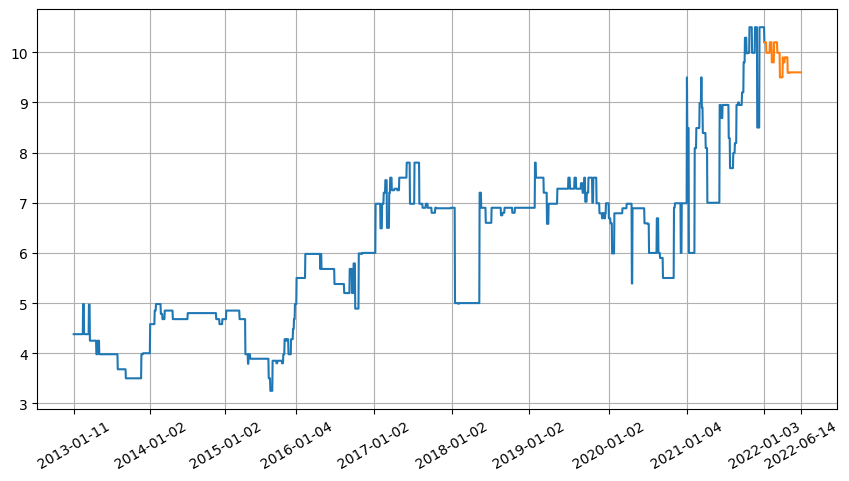

In [7]:
# plotando o gráfico
fig = plt.figure(figsize=(5,4), dpi=100)

axe = fig.add_axes([0.1, 0.1, 1.6, 1])
axe.plot(datas_treino, y_treino)
axe.plot(datas_teste, y_teste)
plt.xticks(array_datas, rotation=30)
plt.grid()

## Rede Neural LSTM

### Construindo uma rede neural LSTM

In [8]:
# modelo sequencial do keras
model = Sequential()
model.add(LSTM(128, input_shape=(pred,1)))
model.add(Dense(64, activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dense(1))

# compilador
model.compile(loss='mse', 
              optimizer=Adam(learning_rate=0.001),
              metrics=['mean_absolute_error'])

In [9]:
# resumo do modelo
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 128)               66560     
                                                                 
 dense (Dense)               (None, 64)                8256      
                                                                 
 dense_1 (Dense)             (None, 64)                4160      
                                                                 
 dense_2 (Dense)             (None, 1)                 65        
                                                                 
Total params: 79,041
Trainable params: 79,041
Non-trainable params: 0
_________________________________________________________________


### Callbacks

In [10]:
# definindo callback
stopper = EarlyStopping(monitor="val_mean_absolute_error",
                        patience=10, verbose=2, mode='min')

### Validação Cruzada

In [11]:
tscv = TimeSeriesSplit(n_splits=15)
rmse_treino = []
rmse_val = []

mape_treino = []
mape_val = []

mae_treino = []
mae_val = []

print(tscv)
for train_index, test_index in tscv.split(X_treino):
    model.fit(X_treino[train_index],
              y_treino[train_index],
              validation_data=(X_treino[test_index], y_treino[test_index]),
              epochs=128,
              verbose=0,
              callbacks=[stopper])
    train_predictions = model.predict(X_treino[train_index]).flatten()
    val_predictions = model.predict(X_treino[test_index]).flatten()
    
    #RMSE
    rmse_treino.append(np.sqrt(mean_squared_error(y_true=y_treino[train_index],
                                                  y_pred=train_predictions)))
    
    rmse_val.append(np.sqrt(mean_squared_error(y_true=y_treino[test_index],
                                                  y_pred=val_predictions)))
    
    #MAE
    mae_treino.append(mean_absolute_error(y_true=y_treino[train_index],
                                                  y_pred=train_predictions))
    mae_val.append(mean_absolute_error(y_true=y_treino[test_index],
                                                  y_pred=val_predictions))
    
    #MAPE
    mape_treino.append(mean_absolute_percentage_error(y_true=y_treino[train_index],
                                                  y_pred=train_predictions))
    mape_val.append(mean_absolute_percentage_error(y_true=y_treino[test_index],
                                                  y_pred=val_predictions))

TimeSeriesSplit(gap=0, max_train_size=None, n_splits=15, test_size=None)
Epoch 12: early stopping
Epoch 49: early stopping
Epoch 21: early stopping
Epoch 53: early stopping
Epoch 17: early stopping
Epoch 38: early stopping
Epoch 29: early stopping
Epoch 25: early stopping
Epoch 11: early stopping
Epoch 40: early stopping
Epoch 16: early stopping
Epoch 18: early stopping
Epoch 18: early stopping
Epoch 19: early stopping
Epoch 31: early stopping


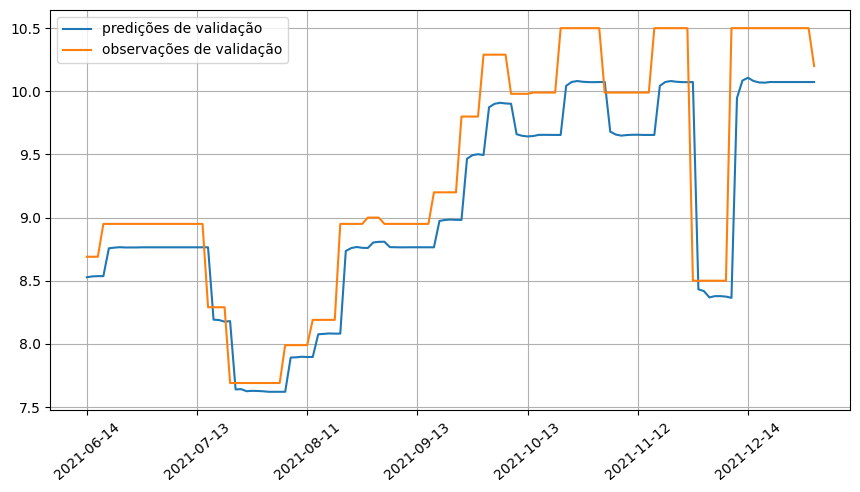

In [12]:
val_predictions = model.predict(X_treino[test_index]).flatten()

fig = plt.figure(figsize=(5,4), dpi=100)
axe = fig.add_axes([0.1, 0.1, 1.6, 1])

axe.plot(datas_treino[-len(val_predictions):], val_predictions)
axe.plot(datas_treino[-len(val_predictions):], y_treino[test_index])
plt.xticks(np.arange(0,datas_treino[-len(val_predictions):].shape[0],20), rotation=40)
axe.legend(['predições de validação', 'observações de validação'])
plt.grid()
plt.show()

In [13]:
print('RMSE médio em treino:', np.mean(rmse_treino))
print('RMSE médio em validação:', np.mean(rmse_val))

print('\nMape médio em treino:', np.mean(mape_treino))
print('Mape médio em validação:', np.mean(mape_val))

print('\nMae médio em treino:', np.mean(mae_treino))
print('Mae médio em validação:', np.mean(mae_val))

RMSE médio em treino: 0.12986696
RMSE médio em validação: 0.19731492

Mape médio em treino: 0.012892177
Mape médio em validação: 0.019037643

Mae médio em treino: 0.06128064
Mae médio em validação: 0.10988603


### Treinando em todo conjunto de treino

In [14]:
# definindo callback
stopper1 = EarlyStopping(monitor="mean_absolute_error",
                        patience=10, verbose=2, mode='min')

model.fit(X_treino,
          y_treino,
          epochs=128,
          verbose=1,
          callbacks=[stopper1])

Epoch 1/128
67/67 [==============================] - 1s 14ms/step - loss: 0.0398 - mean_absolute_error: 0.0888
Epoch 2/128
67/67 [==============================] - 1s 15ms/step - loss: 0.0357 - mean_absolute_error: 0.0684
Epoch 3/128
67/67 [==============================] - 1s 21ms/step - loss: 0.0364 - mean_absolute_error: 0.0745
Epoch 4/128
67/67 [==============================] - 1s 15ms/step - loss: 0.0376 - mean_absolute_error: 0.0767
Epoch 5/128
67/67 [==============================] - 1s 14ms/step - loss: 0.0367 - mean_absolute_error: 0.0742
Epoch 6/128
67/67 [==============================] - 1s 15ms/step - loss: 0.0359 - mean_absolute_error: 0.0707
Epoch 7/128
67/67 [==============================] - 1s 14ms/step - loss: 0.0364 - mean_absolute_error: 0.0694
Epoch 8/128
67/67 [==============================] - 1s 16ms/step - loss: 0.0377 - mean_absolute_error: 0.0769
Epoch 9/128
67/67 [==============================] - 1s 13ms/step - loss: 0.0399 - mean_absolute_error: 0.0930
E

In [15]:
# métricas em treino

train_predictions = model.predict(X_treino).flatten()

print('RMSE:', np.sqrt(mean_squared_error(y_true=y_treino, 
                           y_pred=train_predictions)))

print('MAPE', mean_absolute_percentage_error(y_true=y_treino, 
                           y_pred=train_predictions))

print('MAE', mean_absolute_error(y_true=y_treino, 
                           y_pred=train_predictions))

RMSE: 0.22652885
MAPE 0.024917796
MAE 0.15261897


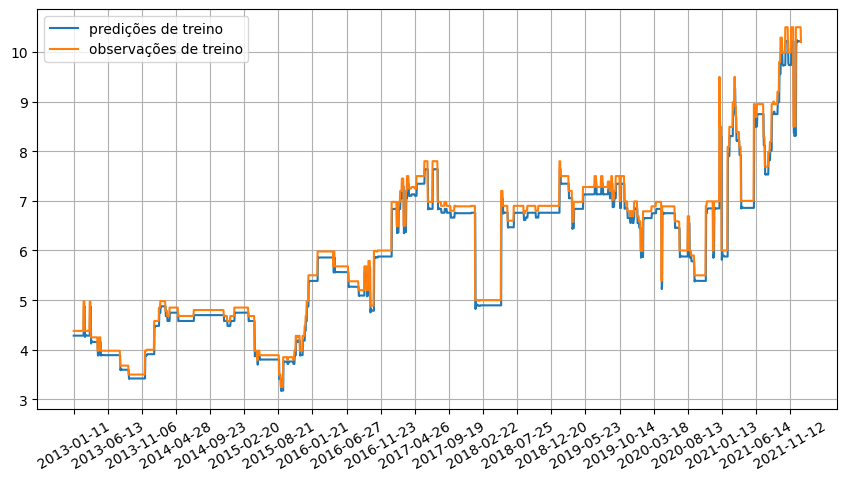

In [16]:
fig = plt.figure(figsize=(5,4), dpi=100)
axe = fig.add_axes([0.1, 0.1, 1.6, 1])

axe.plot(datas_treino, train_predictions)
axe.plot(datas_treino, y_treino)
plt.xticks(np.arange(0,datas_treino.shape[0],100), rotation=30)
axe.legend(['predições de treino', 'observações de treino'])
plt.grid()
plt.show()

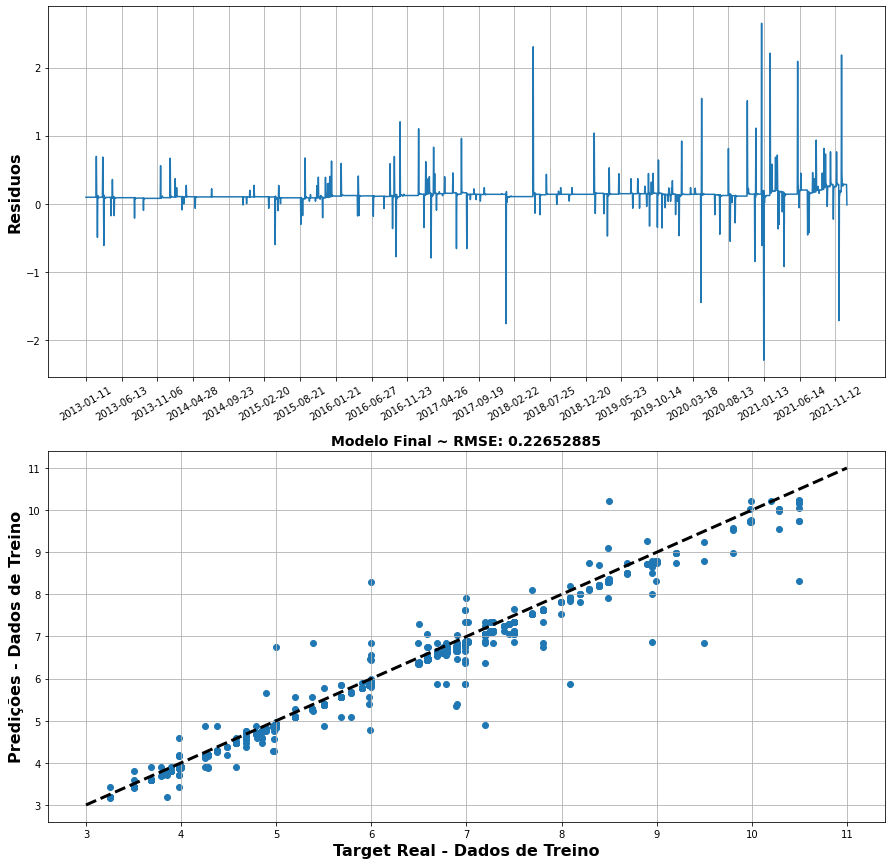

In [17]:
plt.figure(figsize=[15, 15])

plt.subplot(2, 1, 1)
plt.plot(datas_treino, y_treino - train_predictions)
plt.xticks(np.arange(0, datas_treino.shape[0], 100), rotation=30)
plt.ylabel('Residuos', fontweight='bold', fontsize=16)
plt.grid()

plt.subplot(2, 1, 2)
plt.title("Modelo Final ~ RMSE: " + str(np.sqrt(mean_squared_error(y_true=y_treino,
          y_pred=train_predictions))), fontweight='bold', fontsize=14)
plt.scatter(y_treino, train_predictions)
plt.xlabel("Target Real - Dados de Treino", fontweight='bold', fontsize=16)
plt.ylabel("Predições - Dados de Treino", fontweight='bold', fontsize=16)
plt.grid()
range_line = int(np.maximum(max(y_treino), max(train_predictions)))+2
plt.plot(range(int(min(y_treino)), range_line), range(
    int(min(y_treino)), range_line), '--', c='black', lw=3)
plt.show()

### Aplicando modelo em teste

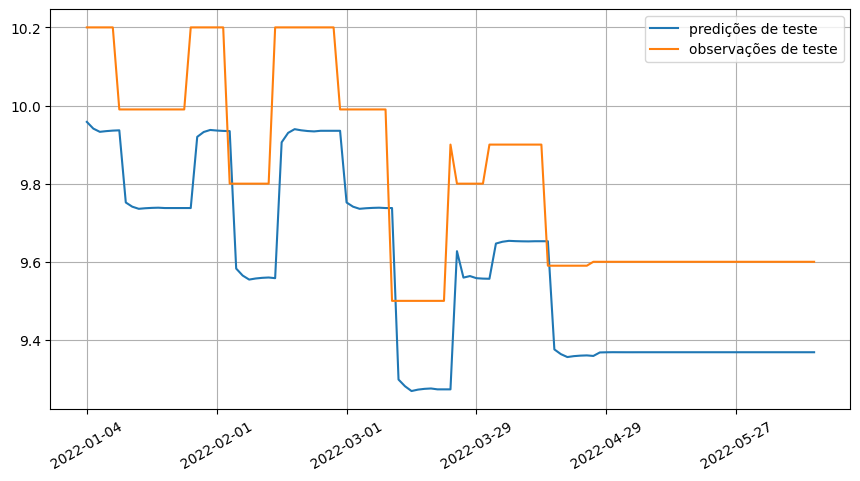

In [18]:
test_predictions = model.predict(X_teste).flatten()

fig = plt.figure(figsize=(5,4), dpi=100)
axe = fig.add_axes([0.1, 0.1, 1.6, 1])

axe.plot(datas_teste, test_predictions)
axe.plot(datas_teste, y_teste)
plt.xticks(np.arange(0,datas_teste.shape[0],20), rotation=30)
axe.legend(['predições de teste', 'observações de teste'])
plt.grid()
plt.show()

In [19]:
# métricas em teste
test_predictions = model.predict(X_teste).flatten()

print('RMSE:', np.sqrt(mean_squared_error(y_true=y_teste, 
                           y_pred=test_predictions)))

print('MAPE', mean_absolute_percentage_error(y_true=y_teste, 
                           y_pred=test_predictions))

print('MAE', mean_absolute_error(y_true=y_teste, 
                           y_pred=test_predictions))

RMSE: 0.25438234
MAPE 0.024957063
MAE 0.24537787


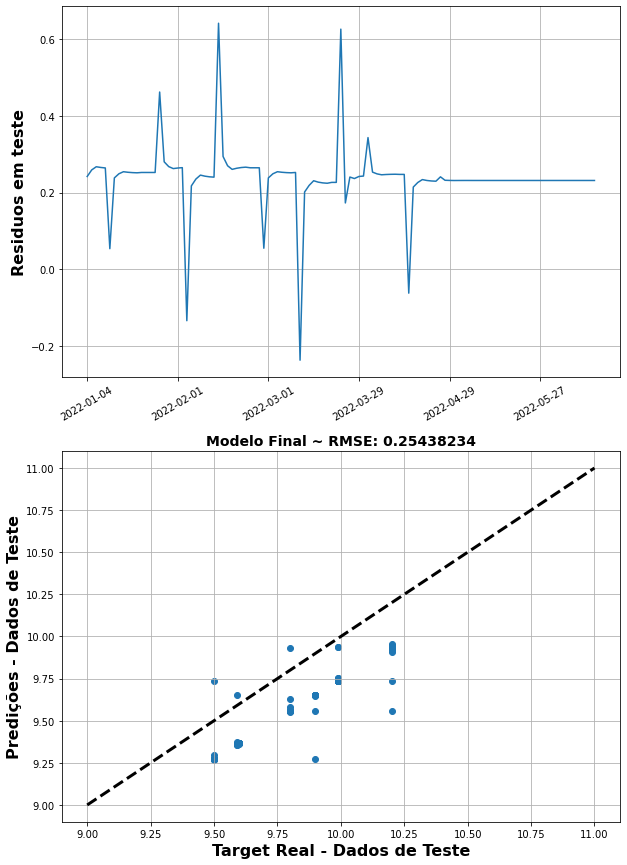

In [20]:
plt.figure(figsize=[10, 15])

plt.subplot(2, 1, 1)
plt.plot(datas_teste, y_teste - test_predictions)
plt.xticks(np.arange(0, datas_teste.shape[0], 20), rotation=30)
plt.ylabel('Residuos em teste', fontweight='bold', fontsize=16)
plt.grid()

plt.subplot(2, 1, 2)
plt.title("Modelo Final ~ RMSE: " + str(np.sqrt(mean_squared_error(y_true=y_teste,
          y_pred=test_predictions))), fontweight='bold', fontsize=14)
plt.scatter(y_teste, test_predictions)
plt.xlabel("Target Real - Dados de Teste", fontweight='bold', fontsize=16)
plt.ylabel("Predições - Dados de Teste", fontweight='bold', fontsize=16)
plt.grid()
range_line = int(np.maximum(max(y_teste), max(test_predictions)))+2
plt.plot(range(int(min(y_teste)), range_line), range(
    int(min(y_teste)), range_line), '--', c='black', lw=3)
plt.show()

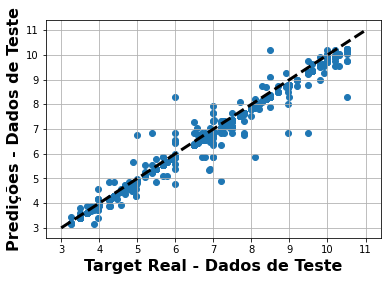

In [21]:
pred_completo = np.append(train_predictions, test_predictions)
real_completo = np.append(y_treino, y_teste)

plt.scatter(real_completo, pred_completo)
plt.xlabel("Target Real - Dados de Teste", fontweight='bold', fontsize=16)
plt.ylabel("Predições - Dados de Teste", fontweight='bold', fontsize=16)
plt.grid()
range_line = int(np.maximum(max(real_completo), max(pred_completo)))+2
plt.plot(range(int(min(real_completo)), range_line), range(
    int(min(real_completo)), range_line), '--', c='black', lw=3)
plt.show()

## Scatterplot multiplo

In [22]:
coluna = 'min'
df = dataset
datas = 'date'
pred = 7

# aplicando 'df_alvos'
df_temp = df_alvos(data=df[coluna],
                   coluna_datas=datas,
                   n=pred)

# aplicando 'df_alvos_separados'
datas, X, y = df_alvos_separados(df_temp)

# aplicando 'treino_teste'

datas_treino, X_treino, y_treino, datas_teste, X_teste, y_teste = treino_validacao_teste(datas,
                                                                                         X,
                                                                                         y,
                                                                                         p_teste=0.05)

# definindo o eixo x para visualização em anos de tudo
lista_datas = [datas[0]]
for item in datas:
    if item[:4] != lista_datas[-1][:4]:
        lista_datas.append(item)
if lista_datas[-1] != datas[-1]:    
    lista_datas.append(datas[-1])
array_datas = np.array(lista_datas)
array_datas

# modelo sequencial do keras
model = Sequential()
model.add(LSTM(128, input_shape=(pred,1)))
model.add(Dense(64, activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dense(1))

# compilador
model.compile(loss='mse', 
              optimizer=Adam(learning_rate=0.001),
              metrics=['mean_absolute_error'])

# definindo callback
stopper1 = EarlyStopping(monitor="mean_absolute_error",
                        patience=10, verbose=2, mode='min')

model.fit(X_treino,
          y_treino,
          epochs=128,
          verbose=1,
          callbacks=[stopper1])

train_predictions = model.predict(X_treino).flatten()
test_predictions = model.predict(X_teste).flatten()

pred_completo_min = np.append(train_predictions, test_predictions)
real_completo_min = np.append(y_treino, y_teste)

coluna = 'max'
df = dataset
datas = 'date'
pred = 7

# aplicando 'df_alvos'
df_temp = df_alvos(data=df[coluna],
                   coluna_datas=datas,
                   n=pred)

# aplicando 'df_alvos_separados'
datas, X, y = df_alvos_separados(df_temp)

# aplicando 'treino_teste'

datas_treino, X_treino, y_treino, datas_teste, X_teste, y_teste = treino_validacao_teste(datas,
                                                                                         X,
                                                                                         y,
                                                                                         p_teste=0.05)

# definindo o eixo x para visualização em anos de tudo
lista_datas = [datas[0]]
for item in datas:
    if item[:4] != lista_datas[-1][:4]:
        lista_datas.append(item)
if lista_datas[-1] != datas[-1]:    
    lista_datas.append(datas[-1])
array_datas = np.array(lista_datas)
array_datas

# modelo sequencial do keras
model = Sequential()
model.add(LSTM(128, input_shape=(pred,1)))
model.add(Dense(64, activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dense(1))

# compilador
model.compile(loss='mse', 
              optimizer=Adam(learning_rate=0.001),
              metrics=['mean_absolute_error'])

# definindo callback
stopper1 = EarlyStopping(monitor="mean_absolute_error",
                        patience=10, verbose=2, mode='min')

model.fit(X_treino,
          y_treino,
          epochs=128,
          verbose=1,
          callbacks=[stopper1])

train_predictions = model.predict(X_treino).flatten()
test_predictions = model.predict(X_teste).flatten()

pred_completo_max = np.append(train_predictions, test_predictions)
real_completo_max = np.append(y_treino, y_teste)

coluna = 'mcom'
df = dataset
datas = 'date'
pred = 7

# aplicando 'df_alvos'
df_temp = df_alvos(data=df[coluna],
                   coluna_datas=datas,
                   n=pred)

# aplicando 'df_alvos_separados'
datas, X, y = df_alvos_separados(df_temp)

# aplicando 'treino_teste'

datas_treino, X_treino, y_treino, datas_teste, X_teste, y_teste = treino_validacao_teste(datas,
                                                                                         X,
                                                                                         y,
                                                                                         p_teste=0.05)

# definindo o eixo x para visualização em anos de tudo
lista_datas = [datas[0]]
for item in datas:
    if item[:4] != lista_datas[-1][:4]:
        lista_datas.append(item)
if lista_datas[-1] != datas[-1]:    
    lista_datas.append(datas[-1])
array_datas = np.array(lista_datas)
array_datas

# modelo sequencial do keras
model = Sequential()
model.add(LSTM(128, input_shape=(pred,1)))
model.add(Dense(64, activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dense(1))

# compilador
model.compile(loss='mse', 
              optimizer=Adam(learning_rate=0.001),
              metrics=['mean_absolute_error'])

# definindo callback
stopper1 = EarlyStopping(monitor="mean_absolute_error",
                        patience=10, verbose=2, mode='min')

model.fit(X_treino,
          y_treino,
          epochs=128,
          verbose=1,
          callbacks=[stopper1])

train_predictions = model.predict(X_treino).flatten()
test_predictions = model.predict(X_teste).flatten()

pred_completo_mcom = np.append(train_predictions, test_predictions)
real_completo_mcom = np.append(y_treino, y_teste)

Epoch 1/128
67/67 [==============================] - 10s 23ms/step - loss: 6.6126 - mean_absolute_error: 1.8157
Epoch 2/128
67/67 [==============================] - 2s 22ms/step - loss: 0.1075 - mean_absolute_error: 0.1880
Epoch 3/128
67/67 [==============================] - 1s 20ms/step - loss: 0.0746 - mean_absolute_error: 0.1567
Epoch 4/128
67/67 [==============================] - 2s 23ms/step - loss: 0.0649 - mean_absolute_error: 0.1342
Epoch 5/128
67/67 [==============================] - 1s 21ms/step - loss: 0.0579 - mean_absolute_error: 0.1195
Epoch 6/128
67/67 [==============================] - 1s 18ms/step - loss: 0.0554 - mean_absolute_error: 0.1195
Epoch 7/128
67/67 [==============================] - 1s 10ms/step - loss: 0.0606 - mean_absolute_error: 0.1399
Epoch 8/128
67/67 [==============================] - 1s 10ms/step - loss: 0.0528 - mean_absolute_error: 0.1130
Epoch 9/128
67/67 [==============================] - 1s 10ms/step - loss: 0.0493 - mean_absolute_error: 0.1023


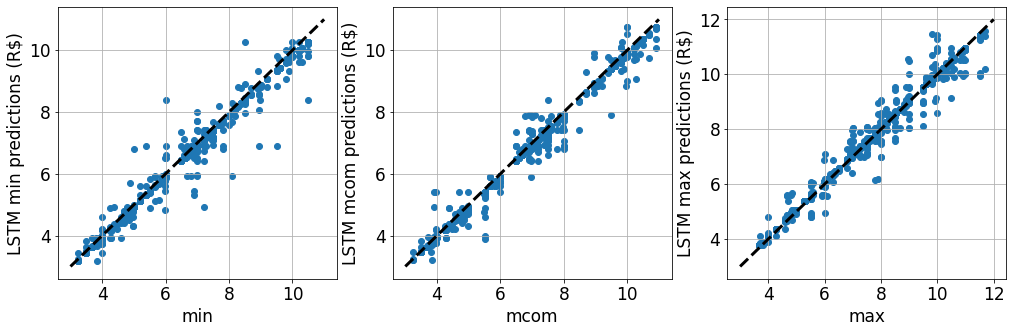

In [25]:
plt.figure(figsize=[17,5])

# Set tick font size
plt.rcParams['xtick.labelsize'] = '17'
plt.rcParams['ytick.labelsize'] = '17'
 
plt.subplot(1,3,1)
plt.scatter(real_completo_min, pred_completo_min)
plt.xlabel("min", fontsize=17)
plt.ylabel('LSTM min predictions (R$)', fontsize=17)
plt.grid()
range_line = int(np.maximum(max(real_completo_min), max(pred_completo_min)))+2
plt.plot(range(int(min(real_completo_min)), range_line), range(
    int(min(real_completo_min)), range_line), '--', c='black', lw=3)

plt.subplot(1,3,2)
plt.scatter(real_completo_mcom, pred_completo_mcom)
plt.xlabel("mcom", fontsize=17)
plt.ylabel('LSTM mcom predictions (R$)', fontsize=17)
plt.grid()
range_line = int(np.maximum(max(real_completo_mcom), max(pred_completo_mcom)))+2
plt.plot(range(int(min(real_completo_mcom)), range_line), range(
    int(min(real_completo_mcom)), range_line), '--', c='black', lw=3)

plt.subplot(1,3,3)
plt.scatter(real_completo_max, pred_completo_max)
plt.xlabel("max", fontsize=17)
plt.ylabel('LSTM max predictions (R$)', fontsize=17)
plt.grid()
range_line = int(np.maximum(max(real_completo_max), max(pred_completo_max)))+2
plt.plot(range(int(min(real_completo_max)), range_line), range(
    int(min(real_completo_max)), range_line), '--', c='black', lw=3)

plt.savefig("High resoltion.jpeg",dpi=400)
plt.show()